In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython import display
from IPython.display import Image
from sklearn.dummy import DummyClassifier
from patsy import dmatrices, build_design_matrices, dmatrix
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

pd.set_option('display.float_format', lambda x: '%.2f' % x)

Using TensorFlow backend.
C:\Users\19145\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\19145\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\19145\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\19145\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

# Download to desktop and upload the file

The file can be found at this link: https://www.kaggle.com/ntnu-testimon/paysim1/downloads/paysim1.zip/2

# Info on the file

**step** - Maps a unit of time in the real world. In this case 1 step is 1 hour of time.

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER

**CASH-IN**: process of increasing the balance of account by paying in cash to a merchant  
**CASH-OUT**: opposite of CASH-IN, withdraw cash from a merchant which decreases the balance of the account  
**DEBIT**: similar to CASH-OUT, involves sending the money from the mobile money service to a bank account  
**PAYMENT**: process of paying for goods or services to merchants. Decreases balance of the account and increases the balance of the receiver.  
**TRANSFER**: sending money to another user of the service through PaySim

**amount** - amount of the transaction in local currency

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - customer's balance after the transaction.

**nameDest** - recipient ID of the transaction.

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [2]:
#upload the dataset
data = pd.read_csv('paysim.csv')

# Get some initial insight on the data

In [3]:
data.tail(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.00,C1812552860,0.00,0.00,1,0
6362611,742,CASH_OUT,63416.99,C994950684,63416.99,0.00,C1662241365,276433.18,339850.17,1,0
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.00,C1470998563,0.00,0.00,1,0
6362613,743,CASH_OUT,1258818.82,C1436118706,1258818.82,0.00,C1240760502,503464.50,1762283.33,1,0
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.00,C1850423904,0.00,0.00,1,0
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.00,C873221189,6510099.11,7360101.63,1,0


In [4]:
#I want to change all of the column names to something cleaner
df = data.rename(columns = {'step':'HoursPassed',
                          'type':'TransactionType',
                          'amount':'Amount',
                          'nameOrig':'OriginatorID',
                          'oldbalanceOrg':'OldBalORIG',
                          'newbalanceOrig':'NewBalORIG', 
                          'nameDest':'RecipientID',
                          'oldbalanceDest':'OldBalRCPT', 
                          'newbalanceDest':'NewBalRCPT', 
                          'isFraud':'Fraud',
                          'isFlaggedFraud':'FlaggedFraud'
                         })

In [5]:
#use the pandas_profiling tool to get a summary of all the data
df.describe()

,HoursPassed,Amount,OldBalORIG,NewBalORIG,OldBalRCPT,NewBalRCPT,Fraud,FlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [6]:
#randomize data order
import sklearn.utils
df = sklearn.utils.shuffle(df)
df = df.reset_index(drop=True)
df.head()

,HoursPassed,TransactionType,Amount,OriginatorID,OldBalORIG,NewBalORIG,RecipientID,OldBalRCPT,NewBalRCPT,Fraud,FlaggedFraud
0,230,CASH_OUT,85989.37,C928125177,11710.00,0.00,C1906601270,0.00,85989.37,0,0
1,40,CASH_OUT,496537.01,C346246370,670.00,0.00,C651632764,0.00,496537.01,0,0
2,230,CASH_OUT,181530.92,C710190184,8071.00,0.00,C1448062020,266588.62,448119.54,0,0
3,12,CASH_OUT,219724.40,C352788113,0.00,0.00,C171294561,1096229.43,2518648.72,0,0
4,217,PAYMENT,6075.90,C2062719047,52614.00,46538.10,M936336228,0.00,0.00,0,0


# Findings and Thoughts

- Transfers and CASH_OUT are related in many transactions. F

In [7]:
#no matching Originator IDs to the Recipient IDs. I assumed this means the originator is not 
df['OriginatorID'].equals(df['RecipientID'])

False

In [8]:
#create dummies for transaction types
df_trans = pd.get_dummies(df['TransactionType'],drop_first=True)
df1 = df
frames = [df1,df_trans]
result = pd.concat(frames,axis=1)

#drop the original transaction types
result = result.drop(columns=['TransactionType'])

In [9]:
#remove all numbers in Originator ID and Recipient ID
result['OriginatorID'] = result['OriginatorID'].str.replace('\d+', '')
result['RecipientID'] = result['RecipientID'].str.replace('\d+', '')

#removing all the numbers in Originator ID leaves only 'C' so I drop the whole column
result = result.drop(columns = ['OriginatorID'])

#do a get_dummies for Recipient ID since there are Merchants ('M') and Customers ('C')
result_recip = pd.get_dummies(result['RecipientID'],drop_first=True)
result1 = result
frames = [result1,result_recip]
new_result = pd.concat(frames,axis=1)

new_result = new_result.drop(columns = ['RecipientID'])

In [10]:
#ok, all of the variables are now either binary or some other numerical value
# new_result.info()
# new_result_tail.describe()
new_result['isFraud'] = new_result['Fraud']
new_result = new_result.drop(columns = ['Fraud'])

In [11]:
#create new columns for difference in Originator ID and Recipient ID
new_result.insert(2, 'ChangeORIG', (new_result['NewBalORIG']-new_result['OldBalORIG']))
new_result.insert(4, 'ChangeRCPT', (new_result['NewBalRCPT']-new_result['OldBalRCPT']))

#drop original ORIG and RCPT transactions and a few others
final_result = new_result.drop(columns = ['HoursPassed','M','OldBalORIG','NewBalORIG','OldBalRCPT','NewBalRCPT','Amount'])
#,'TRANSFER','M','PAYMENT','HoursPassed', 'FlaggedFraud'

In [12]:
#hours aren't as important in this dataset (although out of normal time purchases might occur)
# final_result = final_result.drop(columns = ['HoursPassed'])

In [13]:
print(len(final_result))
print(len(new_result))


6362620
6362620


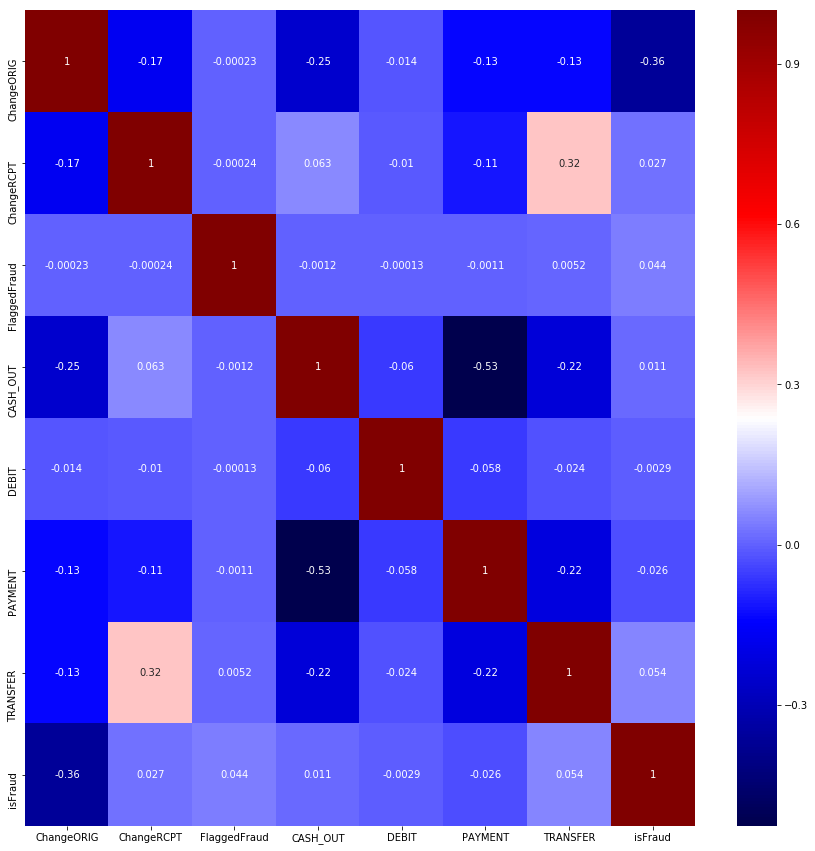

In [14]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(final_result.corr(), cmap="seismic", ax=ax, annot=True)
plt.show()

In [15]:
final_result.head()

,ChangeORIG,ChangeRCPT,FlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
0,-11710.00,85989.37,0,1,0,0,0,0
1,-670.00,496537.01,0,1,0,0,0,0
2,-8071.00,181530.92,0,1,0,0,0,0
3,0.00,1422419.29,0,1,0,0,0,0
4,-6075.90,0.00,0,0,0,1,0,0


In [16]:
#remove duplicate entries
result_df = final_result.drop_duplicates(['ChangeORIG'],keep='first')

In [18]:
print(len(result_df))


2962285


In [19]:
#drop fraud cases to avoid data leakage
d = result_df.drop(columns=['isFraud'])
print(len(d))

2962285


0    2958434
1       3851
Name: isFraud, dtype: int64


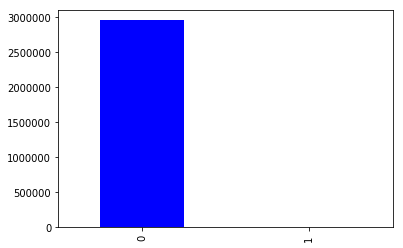

In [20]:
# data.info()
#EDA and Baselining
target_pcts = result_df.isFraud.value_counts(normalize=False)
print(result_df.isFraud.value_counts(normalize=False))
target_pcts.plot(kind='bar', color='blue');

# Train-test-split with downsampling

In [21]:
X_break, X_test, y_break, y_test = train_test_split(d, result_df['isFraud'], \
                                                    test_size=0.2, stratify=result_df['isFraud'],
                                                    random_state=42)
#X_break, X_test, y_break, y_test = train_test_split(no_fraud_result, result_df['isFraud'], \
#                                                    test_size=0.2, stratify=result_df['isFraud'],
#                                                    random_state=42)
#random_state generates a set kind of deck for each random state. 41 will always be the same kind of split

X_train, X_val, y_train, y_val = train_test_split(X_break, y_break, \
                                                    test_size=0.25, stratify=y_break,
                                                    random_state=42)

In [22]:
# Normalize my variables
scaler = StandardScaler()
scaler.fit(X_train)
X_train_SVC = scaler.transform(X_train)
X_val_SVC = scaler.transform(X_val)

C:\Users\19145\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\19145\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\19145\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


In [23]:
X_train_under, y_train_under = RandomUnderSampler(random_state=42).fit_sample(X_train,y_train)
X_val_under, y_val_under = RandomUnderSampler(random_state=42).fit_sample(X_val,y_val)
X_train_under_SVC, y_train_under_SVC = RandomUnderSampler(random_state=42).fit_sample(X_train_SVC,y_train)

# Create Models

## KNN

In [24]:
# Run CV with 5 folds (knn)

ks = [1,5,10]
param_grid = [{'n_neighbors': ks}]

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)
knn_grid.fit(X_train_under, y_train_under)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_neighbors': [1, 5, 10]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

## Logistic Regression (Logit)

In [25]:
# Run CV with 5 folds (logit)

penalty = ['l2']
C = np.logspace(0, 4, 10)
param_grid = dict(C=C, penalty=penalty)

logit = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_grid = GridSearchCV(logit, param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)
logistic_grid.fit(X_train_under, y_train_under)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([    1.     ,     2.78256,     7.74264,    21.54435,    59.94843,
         166.81005,   464.15888,  1291.54967,  3593.81366, 10000.     ]), 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [26]:
# using the new threshold of n
def check_threshold(n):
    y_predict = (logit.predict_proba(X_val_under)[:,1] > float(n))
    print(f'Threshold of {n}:')
    print('Precision: {:6.4f},   Recall: {:6.4f}'.format(precision_score(y_val_under, y_predict), 
                                                     recall_score(y_val_under, y_predict)))
    print(f'Total Score: {precision_score(y_val_under, y_predict) + recall_score(y_val_under, y_predict)}')
    print('')

In [27]:
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = logistic_grid.predict(X_val_under)
print("Default threshold: 0.5")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val_under, y_predict), 
                                                     recall_score(y_val_under, y_predict)))

Default threshold: 0.5
Precision: 0.6704,   Recall: 0.9987


## Naive Bayes

In [28]:
# Fit a Naive Bayes Model

gnb = GaussianNB()
gnb_best = gnb.fit(X_train_under, y_train_under)

## Support Vector Machine (SVM) w/ Radial Basis Function (RBF)

In [29]:
# Run CV with 5 folds (SVM).

C = [1,2,5,10]
gammas = [0.001, 0.1]
param_grid = dict(C=C, gamma=gammas)

svm1 = svm.SVC(kernel='rbf', probability=True)
svm_grid = GridSearchCV(svm1, param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)
svm_grid.fit(X_train_under, y_train_under)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1, 2, 5, 10], 'gamma': [0.001, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

## Random Forest

In [30]:
# Run CV with 5 folds (Random Forest)

# Number of trees in random forest
n_estimators = [100,250,500]#[200, 250] #200 or 250 models. test this more
# Number of features to consider at every split
max_features = ['auto'] #sqrt
# Maximum number of levels in tree
max_depth = [40,80,200]#[70, 80]
# Minimum number of samples required to split a node
min_samples_split = [2,5,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,4]#[1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth, #how deep the tree gets to go, test this more
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

# #looking for the best hyperparams
# #Create base model to tune
rfc=RandomForestClassifier()

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, verbose=0, n_jobs=-1)
CV_rfc.fit(X_train_under, y_train_under)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 250, 500], 'max_features': ['auto'], 'max_depth': [40, 80, 200], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 4], 'bootstrap': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# Check out Scores and ROC curves

In [31]:
print('Best ROC_AUC for logit: %0.4f' % logistic_grid.best_score_)
print('Best ROC_AUC for svm: %0.4f' % svm_grid.best_score_)
print('Best ROC_AUC for rf: %0.4f' % CV_rfc.best_score_)

Best ROC_AUC for logit: 0.9677
Best ROC_AUC for svm: 0.7199
Best ROC_AUC for rf: 0.9474






























































## Dummy Classifier (as a baseline)

In [32]:
dc = DummyClassifier()
dc.fit(X_train_under, y_train_under)
# print("Log-loss on dummy classifier: {:6.4f}".format(log_loss(y_val, dc.predict_proba(X_val))))

DummyClassifier(constant=None, random_state=None, strategy='stratified')

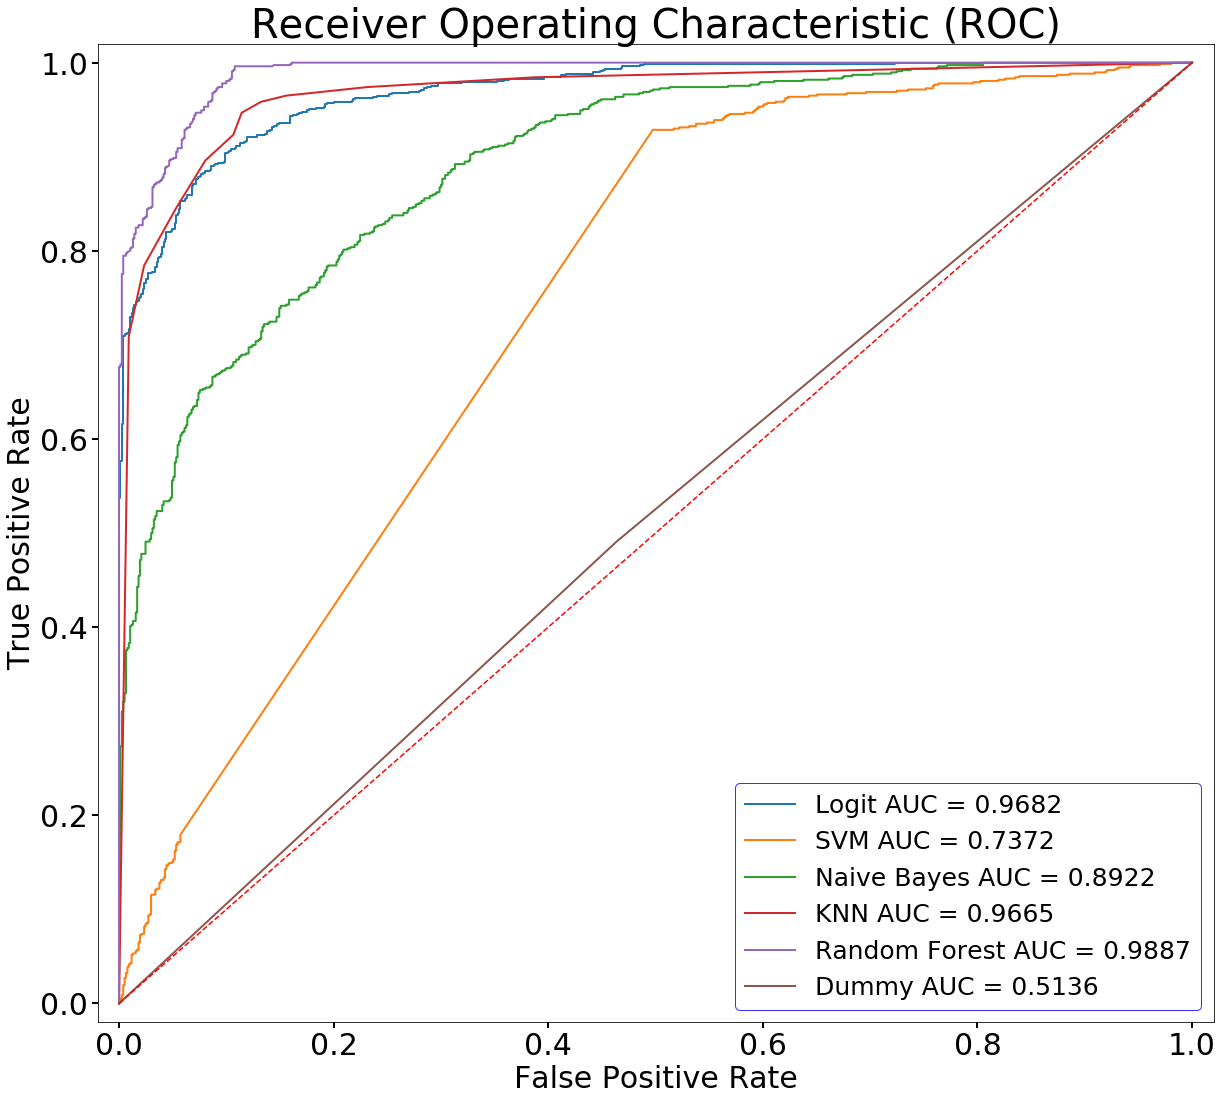

In [33]:
#in sample
plt.rcParams.update({'font.size': 30})
model_list = [logistic_grid.best_estimator_, 
              svm_grid.best_estimator_, 
              gnb_best,
#               rf_random.best_estimator_,
              knn_grid.best_estimator_,
              CV_rfc.best_estimator_,
              dc
             ]

model_name = ['Logit','SVM','Naive Bayes', 'KNN','Random Forest','Dummy']
 
# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(20,18))
for i, model in enumerate(model_list):
    y_pred = list(model.predict_proba(X_val_under)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_val_under, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc),linewidth=2.0)
ax.grid(False)
ax.tick_params(length=6, width=2,labelsize = 30,
               grid_color='r', grid_alpha=0.5)
# plt.legend(loc = 'lower right',prop={'size': 25})
leg = plt.legend(loc = 'lower right',prop={'size': 25})
leg.get_frame().set_edgecolor('b')
plt.title('Receiver Operating Characteristic (ROC)', FontSize=40)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-.02, 1.02])
plt.ylim([-.02, 1.02])
plt.ylabel('True Positive Rate',FontSize=30)
plt.xlabel('False Positive Rate',FontSize=30)
plt.show()

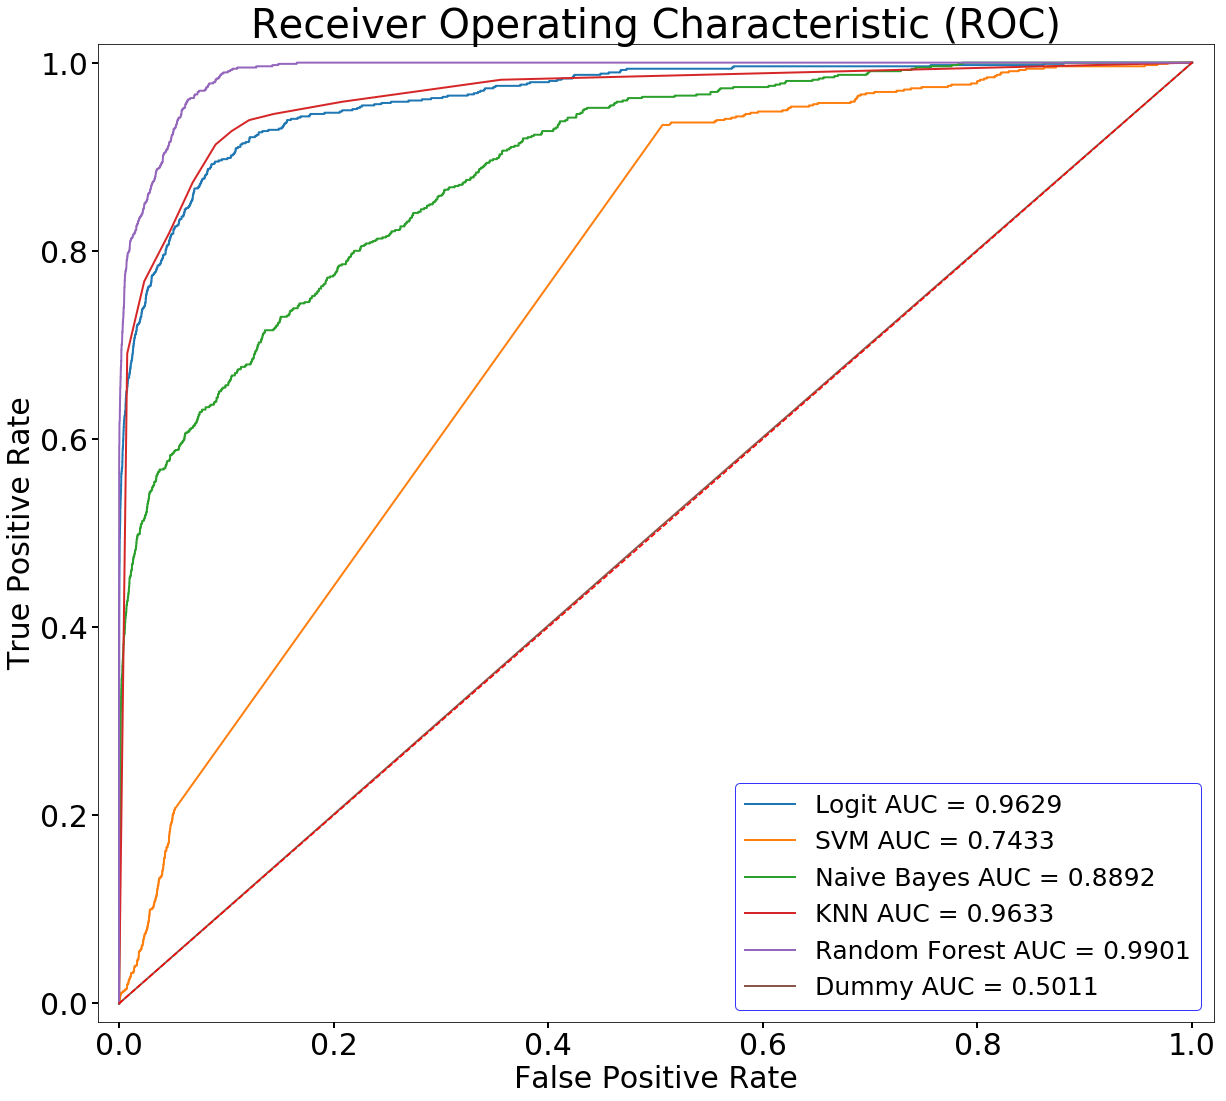

In [34]:
#out of sample
plt.rcParams.update({'font.size': 30})
model_list = [logistic_grid.best_estimator_, 
              svm_grid.best_estimator_, 
              gnb_best,
#               rf_random.best_estimator_,
              knn_grid.best_estimator_,
              CV_rfc.best_estimator_,
              dc
             ]

model_name = ['Logit','SVM','Naive Bayes', 'KNN','Random Forest','Dummy']
 
# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(20,18))
for i, model in enumerate(model_list):
    y_pred = list(model.predict_proba(X_test)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc),linewidth=2.0)
ax.grid(False)
ax.tick_params(length=6, width=2,labelsize = 30,
               grid_color='r', grid_alpha=0.5)
# plt.legend(loc = 'lower right',prop={'size': 25})
leg = plt.legend(loc = 'lower right',prop={'size': 25})
leg.get_frame().set_edgecolor('b')
plt.title('Receiver Operating Characteristic (ROC)', FontSize=40)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-.02, 1.02])
plt.ylim([-.02, 1.02])
plt.ylabel('True Positive Rate',FontSize=30)
plt.xlabel('False Positive Rate',FontSize=30)
plt.show()

# See Feature Importance

In [35]:
for item1,item2 in zip(X_test.columns,CV_rfc.best_estimator_.feature_importances_):
    print(f'{item1} has a score of {item2}')

ChangeORIG has a score of 0.46905464948777537
ChangeRCPT has a score of 0.2128627959465762
FlaggedFraud has a score of 0.0
CASH_OUT has a score of 0.09521763423038447
DEBIT has a score of 0.0008933682676451935
PAYMENT has a score of 0.05944837199116309
TRANSFER has a score of 0.16252318007645578


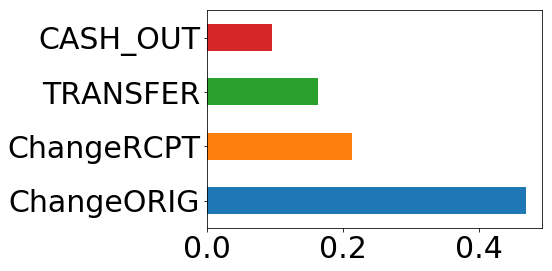

In [36]:
#using only RFC
feat_importances = pd.Series(CV_rfc.best_estimator_.feature_importances_, index=X_val.columns)
feat_importances.nlargest(4).plot(kind='barh')

# Finding F1 Score and Threshold

In [37]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

model_dict = {'rfc': RandomForestClassifier(n_estimators = 400, n_jobs = -1,max_features = 'sqrt'),
             'lm' : LogisticRegression(max_iter =10000,solver='sag',verbose = 10,n_jobs = -1),
             'gnb' : GaussianNB(),
             'mlp' : MLPClassifier(verbose = 10),
             'gbc' : GradientBoostingClassifier(n_estimators =  1000, max_leaf_nodes = 4,\
                                                max_depth = None ,min_samples_split = 5, verbose = 10,
                                               learning_rate = .1)}


In [38]:
def make_model(mdl_key,X_train,y_train,X_test):
    """Uses key from model_dict and trains it on X_train, y_train, then returns \
    the model object used and predicted values on X_test"""
    assert (mdl_key in model_dict.keys()),"Model tag not in model_dict keys!"
    mdl = model_dict[mdl_key]
    mdl.fit(X_train,y_train)
    predicted = mdl.predict(X_test)
    return mdl, predicted

In [39]:
rfc, gnb_predicted = make_model('rfc',X_train_under,y_train_under,X_val_under) 

In [40]:
lm, predicted = make_model('lm',X_train_under,y_train_under,X_val_under)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 318 epochs took 1 seconds


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


In [41]:
gnb, gnb_predicted = make_model('gnb',X_train_under,y_train_under,X_val_under)

In [42]:
mlp, mlp_predicted = make_model('mlp',X_train_under,y_train_under,X_val_under)

Iteration 1, loss = 7.81067163
Iteration 2, loss = 6.14565812
Iteration 3, loss = 5.59105670
Iteration 4, loss = 5.33385908
Iteration 5, loss = 5.27887399
Iteration 6, loss = 5.24500576
Iteration 7, loss = 5.14672059
Iteration 8, loss = 5.20828837
Iteration 9, loss = 5.47214685
Iteration 10, loss = 5.68397114
Iteration 11, loss = 5.47148305
Iteration 12, loss = 5.04383860
Iteration 13, loss = 4.23983425
Iteration 14, loss = 5.15671368
Iteration 15, loss = 5.54705820
Iteration 16, loss = 5.34708403
Iteration 17, loss = 5.05140099
Iteration 18, loss = 5.35379908
Iteration 19, loss = 5.34716986
Iteration 20, loss = 5.28985826
Iteration 21, loss = 5.18525241
Iteration 22, loss = 5.40478461
Iteration 23, loss = 4.86167675
Iteration 24, loss = 5.09379977
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [43]:
gbc, gbc_predicted = make_model('gbc',X_train_under,y_train_under,X_val_under)

      Iter       Train Loss   Remaining Time 
         1           1.2505            2.06m
         2           1.1350            1.19m
         3           1.0375           47.40s
         4           0.9557           35.51s
         5           0.8868           28.38s
         6           0.8270           26.22s
         7           0.7764           22.45s
         8           0.7285           19.62s
         9           0.6870           17.42s
        10           0.6513           15.67s
        11           0.6154           14.23s
        12           0.5860           14.32s
        13           0.5594           13.20s
        14           0.5359           12.25s
        15           0.5131           14.51s
        16           0.4943           14.43s
        17           0.4748           13.68s
        18           0.4601           13.07s
        19           0.4425           12.52s
        20           0.4305           12.04s
        21           0.4174           11.76s
        2

       185           0.1823            3.02s
       186           0.1822            3.01s
       187           0.1819            3.00s
       188           0.1818            2.99s
       189           0.1816            2.98s
       190           0.1815            2.97s
       191           0.1812            2.96s
       192           0.1810            2.95s
       193           0.1808            2.95s
       194           0.1806            2.94s
       195           0.1804            2.93s
       196           0.1802            2.93s
       197           0.1799            2.92s
       198           0.1798            2.91s
       199           0.1796            2.90s
       200           0.1794            2.89s
       201           0.1792            2.88s
       202           0.1789            2.87s
       203           0.1788            2.86s
       204           0.1786            2.85s
       205           0.1783            2.84s
       206           0.1782            2.83s
       207

       405           0.1445            1.71s
       406           0.1444            1.71s
       407           0.1443            1.70s
       408           0.1442            1.70s
       409           0.1441            1.69s
       410           0.1440            1.69s
       411           0.1439            1.69s
       412           0.1438            1.68s
       413           0.1436            1.68s
       414           0.1435            1.67s
       415           0.1434            1.67s
       416           0.1434            1.67s
       417           0.1433            1.66s
       418           0.1432            1.66s
       419           0.1432            1.66s
       420           0.1430            1.65s
       421           0.1427            1.65s
       422           0.1425            1.64s
       423           0.1424            1.64s
       424           0.1423            1.64s
       425           0.1421            1.63s
       426           0.1421            1.63s
       427

       618           0.1200            1.00s
       619           0.1199            1.00s
       620           0.1197            1.00s
       621           0.1197            0.99s
       622           0.1196            0.99s
       623           0.1195            0.99s
       624           0.1194            0.98s
       625           0.1194            0.98s
       626           0.1192            0.98s
       627           0.1190            0.98s
       628           0.1189            0.97s
       629           0.1188            0.97s
       630           0.1187            0.97s
       631           0.1187            0.97s
       632           0.1186            0.96s
       633           0.1185            0.96s
       634           0.1182            0.96s
       635           0.1181            0.95s
       636           0.1180            0.95s
       637           0.1179            0.95s
       638           0.1178            0.95s
       639           0.1178            0.94s
       640

       812           0.1027            0.46s
       813           0.1025            0.46s
       814           0.1025            0.46s
       815           0.1024            0.46s
       816           0.1024            0.45s
       817           0.1023            0.45s
       818           0.1023            0.45s
       819           0.1022            0.45s
       820           0.1021            0.44s
       821           0.1021            0.44s
       822           0.1020            0.44s
       823           0.1019            0.44s
       824           0.1019            0.43s
       825           0.1018            0.43s
       826           0.1017            0.43s
       827           0.1017            0.43s
       828           0.1016            0.42s
       829           0.1016            0.42s
       830           0.1015            0.42s
       831           0.1015            0.42s
       832           0.1014            0.41s
       833           0.1014            0.41s
       834